In [1]:
#STEP 1 — Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, LSTM, Dense,
    Dropout, BatchNormalization
)
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#STEP 2 — Load Dataset
df = pd.read_csv('/content/adhdata.csv', low_memory=False)
print("✅ Dataset loaded successfully.")
print("Shape:", df.shape)
display(df.head())

✅ Dataset loaded successfully.
Shape: (2166383, 21)


,Fp1,Fp2,F3,F4,C3,C4,P3,P4,O1,O2,...,F8,T7,T8,P7,P8,Fz,Cz,Pz,Class,ID
0,261.0,402.0,16.0,261.0,126.0,384.0,126.0,236.0,52.0,236.0,...,16.0,200.0,494.0,126.0,236.0,121.0,367.0,121.0,ADHD,v10p
1,121.0,191.0,-94.0,85.0,16.0,200.0,126.0,52.0,347.0,273.0,...,-57.0,126.0,347.0,52.0,52.0,15.0,121.0,-19.0,ADHD,v10p
2,-55.0,85.0,-204.0,15.0,-57.0,200.0,52.0,126.0,236.0,200.0,...,-94.0,126.0,420.0,52.0,126.0,-55.0,261.0,85.0,ADHD,v10p
3,191.0,85.0,52.0,50.0,89.0,236.0,163.0,89.0,89.0,89.0,...,-57.0,236.0,420.0,126.0,126.0,15.0,85.0,-55.0,ADHD,v10p
4,-55.0,-125.0,-204.0,-160.0,-204.0,16.0,-241.0,-241.0,89.0,16.0,...,-131.0,89.0,310.0,-57.0,52.0,-55.0,15.0,-336.0,ADHD,v10p


In [3]:
# STEP 3 — Encode Target and Drop ID
df['Class'] = df['Class'].map({'ADHD': 1, 'Control': 0})
if 'ID' in df.columns:
    df = df.drop(columns=['ID'])

print("\n📊 Class distribution:\n", df['Class'].value_counts())


📊 Class distribution:
 Class
1    1207069
0     959314
Name: count, dtype: int64


In [4]:
#STEP 4 — Define Features and Target
X = df.drop(columns=['Class'])
y = df['Class']

In [5]:
# STEP 5 — Split BEFORE Scaling (to avoid data leakage)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("\n✅ Data split completed.")
print("Train shape:", X_train.shape, " Test shape:", X_test.shape)



✅ Data split completed.
Train shape: (1733106, 19)  Test shape: (433277, 19)


In [6]:
# STEP 6 — Scale Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("\n✅ Features scaled successfully.")


✅ Features scaled successfully.


In [7]:
# STEP 7 — Reshape for CNN + LSTM (3D Input)
# CNN/LSTM expects input: (samples, time_steps, features)
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)
print("✅ Reshaped data for CNN–LSTM:", X_train_reshaped.shape)

✅ Reshaped data for CNN–LSTM: (1733106, 19, 1)


In [8]:
# STEP 8 — Build CNN + LSTM Model
model = Sequential([
    # --- CNN block ---
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    # --- LSTM block ---
    LSTM(64, return_sequences=False),
    Dropout(0.3),

    # --- Dense block ---
    Dense(32, activation='relu'),
    Dropout(0.3),

    # --- Output layer ---
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 17, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 17, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,649 (139.25 KB)

 Trainable params: 35,521 (138.75 KB)

 Non-trainable params: 128 (512.00 B)

In [9]:
# STEP 9 — Train Model
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_reshaped, y_train,
    validation_data=(X_test_reshaped, y_test),
    epochs=20,
    batch_size=2048,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
847/847 ━━━━━━━━━━━━━━━━━━━━ 191s 220ms/step - accuracy: 0.6388 - auc: 0.6741 - loss: 0.6361 - val_accuracy: 0.6995 - val_auc: 0.7587 - val_loss: 0.5758
Epoch 2/20
847/847 ━━━━━━━━━━━━━━━━━━━━ 182s 214ms/step - accuracy: 0.6922 - auc: 0.7452 - loss: 0.5865 - val_accuracy: 0.7197 - val_auc: 0.7843 - val_loss: 0.5510
Epoch 3/20
847/847 ━━━━━━━━━━━━━━━━━━━━ 180s 212ms/step - accuracy: 0.7077 - auc: 0.7660 - loss: 0.5681 - val_accuracy: 0.7285 - val_auc: 0.7957 - val_loss: 0.5394
Epoch 4/20
847/847 ━━━━━━━━━━━━━━━━━━━━ 209s 221ms/step - accuracy: 0.7166 - auc: 0.7777 - loss: 0.5573 - val_accuracy: 0.7355 - val_auc: 0.8054 - val_loss: 0.5288
Epoch 5/20
847/847 ━━━━━━━━━━━━━━━━━━━━ 178s 210ms/step - accuracy: 0.7242 - auc: 0.7868 - loss: 0.5484 - val_accuracy: 0.7433 - val_auc: 0.8124 - val_loss: 0.5202
Epoch 6/20
847/847 ━━━━━━━━━━━━━━━━━━━━ 213s 224ms/step - accuracy: 0.7301 - auc: 0.7928 - loss: 0.5415 - val_accuracy: 0.7466 - val_auc: 0.8170 - val_loss: 0.5148
Epoch 7/20
847/8

In [10]:
# STEP 10 — Evaluate Model
y_prob = model.predict(X_test_reshaped).ravel()
y_pred = (y_prob > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\n📈 Final CNN–LSTM Model Results:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC-AUC:   {auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

13540/13540 ━━━━━━━━━━━━━━━━━━━━ 46s 3ms/step

📈 Final CNN–LSTM Model Results:
Accuracy:  0.7692
Precision: 0.7634
Recall:    0.8487
F1-score:  0.8038
ROC-AUC:   0.8425

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.67      0.72    191863
           1       0.76      0.85      0.80    241414

    accuracy                           0.77    433277
   macro avg       0.77      0.76      0.76    433277
weighted avg       0.77      0.77      0.77    433277



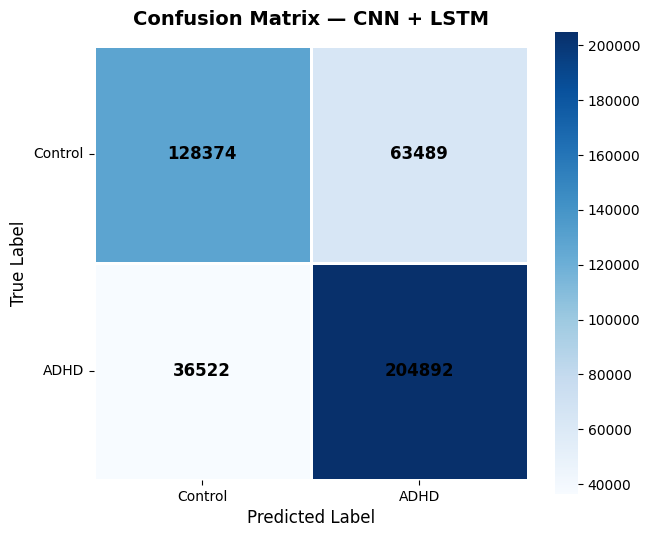

In [11]:
# STEP 11 — Confusion Matrix (Styled)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues', cbar=True, square=True,
    linewidths=1, linecolor='white',
    annot_kws={"size": 12, "weight": "bold", "color": "black"}
)
plt.title("Confusion Matrix — CNN + LSTM", fontsize=14, weight='bold', pad=15)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks([0.5, 1.5], ['Control', 'ADHD'])
plt.yticks([0.5, 1.5], ['Control', 'ADHD'], rotation=0)
plt.show()

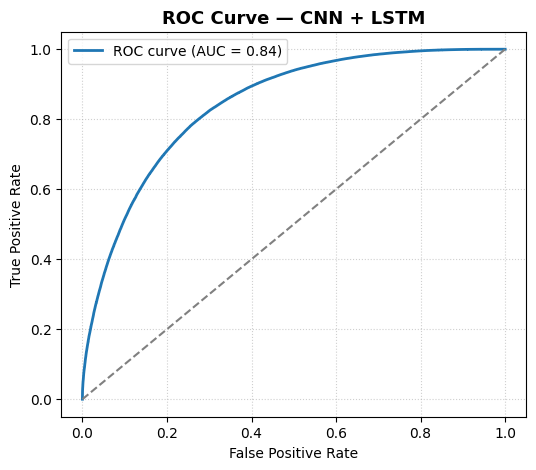

In [12]:
# STEP 12 — ROC Curve Visualization
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='#1f77b4', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.title("ROC Curve — CNN + LSTM", fontsize=13, weight='bold')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()


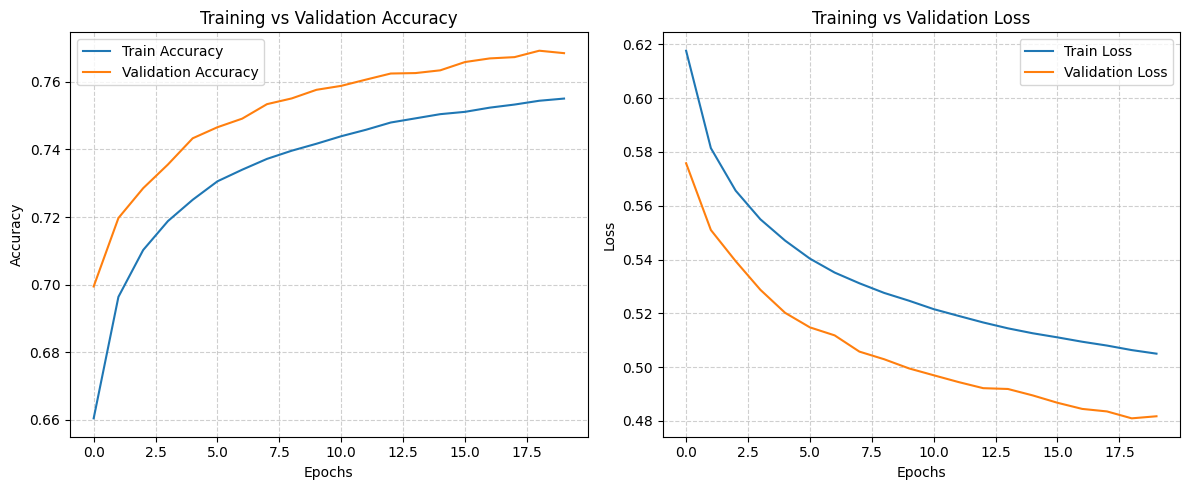

In [13]:
# STEP 13 — Training Curves (Accuracy & Loss)
plt.figure(figsize=(12,5))

# Accuracy curve
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Loss curve
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()